# Real-Time Change Detection on Streaming Data

https://github.com/codyrioux/pydata2015seattle/

In this tutorial we will be tackling the task of online change detection in data streams, which is perhaps unsurprisingly detecting "change" in streams of data in real-time. The objective of this tutorial is to get you from zero to being capable of detecting change and potentially implementing your own solutions. We will use the following formal definition for our problem:

> If we have an ordered incoming stream of observations at discrete time intervals, then we can imagine there is some underlying generating mechanism producing the observations we are receiving in this stream. The problem of detecting change is then simply inferring from the observation stream if there has been a change to the underlying generating mechanism.

For practical purposes in this tutorial we will use streams of doubles either generated by a synthetic data generator or a previously captured data stream at Netflix, however the objective is to explore online techniques which operate on data streams which we have not yet completely captured. To this end we will be generating synthetic data streams and processing previously captured data in a streaming fashion.

A great example of detecting change in an offline fashion would in the first chapter of Cam's book [Bayesian Methods for Hackers](http://nbviewer.ipython.org/github/CamDavidsonPilon/Probabilistic-Programming-oand-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Chapter1.ipynb) in which he takes approximately two months of daily text message counts and attempts to determine if his texting habits changed over the course of the month. I've shamelessly lifted the image, and his data looks like this:

<img src="texting.png">

The analysis performed identifies likely distributions for texting habits before and after the change, as well as the most probable days for the change. We would likel to do this in an online fashion, and we'll be satisfied with detecting the point of change as accurately as possible. Reimagine this problem except processing the days one at a time each day and triggering an alert when we suspect the stream's generator has changed. Lets observe a handful of examples which display different change behaviors that we would like to detect: 

<img src="change1.png">
<img src="change2.png">
<img src="change3.png">

So where might you find something like this useful? The answer is any metric on which it would be useful to be alerted of change might be effective. This may be a metric as simple as something that should stay relatively constant such as the temperature in a server room (a threshold may be more appropriate here but you get the idea) or something that drifts over time such as signups per hour for a small startup. At Netflix change detection is part of a larger analytics suite and is often used in conjuction with other analytics but one excellent example of where its used is the call volume for a specific device in our call centre. If the generating mechanism for this has changed it is a strong indicator that the device may be experiencing an issue streaming Netflix.

TODO: Insert Call Volume Graph

## Challenges

There are a number of challenges when dealing with detecting change in real-time, I'll outline a few of them here so you can think about them while we go through this tutorial.

- False Positives: Detecting change when there is none, an algorithm that is too sensitive. This is especially an issue in production when mathematical change doesn't necessarily imply change that a human cares about.
- False Negatives: Failing to detect change when there is some change, an algorithm that is too insensitive.
- Detection Lag: How quickly are we able to detect change?

Different techniques will address these challenges differently, some will be weak in some areas and strong in others. Furthermore it depends on the characteristics of our data streams. Later when implementing your own solutions consider how they'll interact with the points above.


## Components
We require a handful of components to solve this problem effectively. These components include a simulator, change detector base classes, data generators and evaluation functions. Together these components can be used to construct and evaluate experiments against one another. A number of components are included in this package, though they've been kept intentionally simple for understandability. They should however also form an excellent base for a more robust system should you chose to implement any of these components directly. We'll require the following components:


- Detector Framework
- Data Generators
- Simulation Framework
- Evaluation Functions

- Basic Change Detector (Normal Approximation)
- Bayesian Change Detector


# Tutorial Schedule

This tutorial is slated to be 110 minutes long, I can't imagine talking for 110 minutes. I've got just over an hour of material, the rest will be Q&A or an early release.

- Introduction: 10 Minutes
- Generators: 15 Minutes
- Evaluation Functions: 5 Minutes
- Framework (Simulator + Detectors): 10 Minutes
- Simple Detector: 10 Minutes

- Bayesian Detector: 20 Minutes
- Case Study: 10 Minutes
- Q&A: 30 Minutes

# TODO

- Bayes Detector [Code]
- Upload to github
- Put on USB Stick

In [2]:
%matplotlib inline
import math
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque
import copy

#Data
A typical concern when working on streaming algorithms is data collection. If you've ever attempted to build or acquire a large well curated data set you know that its expensive on either time or money depending on how you go about it. Streaming data is even more of a problem because unless you capture the data it is lost, and sometimes the data is streamed because its too expensive to store.

Possible solutions to this are to observe your data stream and capture the necessary data, but you still need to manually process it and tag the data. We've got some captured data from Netflix in this tutorial, but its not enough... Another solution commonly applied to this problem is synthetic data generation. We'll create a class of data generators which create fake datasets for us with known changepoints for the purposes of testing our algorithms against a large number of data streams.

In [230]:
class Generator(object):
    
    def __init__(self):
        self._changepoint = -1
    
    def get(self):
        self._changepoint += 1
        return 1.0
    
class DistributionGenerator(Generator):
    """
    A generator which generates values from a single distribution. This may not immediately
    appear useful for change detection, however if we can model our unchanged data stream
    as a distribution then we can test against false positives by running tests against
    a single distribution.
    
    dist1:  A scipy.stats distribution for before changepoint.
    kwargs: The keyword arguments are passed to the distribution.
    """
    
    def __init__(self, dist, **kwargs):
        self._dist = dist
        self._args = kwargs
        
    def get(self):
        return self._dist.rvs(**self._args)

    
class ChangingDistributionGenerator(Generator):
    """
    A generator which takes two distinct distributions and a changepoint and returns
    random variates from the first distribution until it has reached the changepoint
    when it then switches to the next.
    
    dist1:       A scipy.stats distribution for before changepoint.
    kwargs1:     A map specifying loc and scale for dist1.
    dist2:       A scipy.stats distribution for after changepoint.
    kwargs2:     A map specifying loc and scale for dist2.
    changepoint: The number of values to be generated before switching to dist2.
    """
    
    _position = 0
    
    def __init__(self, dist1, kwargs1, dist2, kwargs2, changepoint):
        self._dist1 = dist1
        self._kwargs1 = kwargs1
        self._dist2 = dist2
        self._kwargs2 = kwargs2
        self._changepoint = changepoint
        
    def get(self):
        self._position += 1
        if self._position <= self._changepoint:
            return self._dist1.rvs(**self._kwargs1)
        else:
            return self._dist2.rvs(**self._kwargs2)

        
class DriftGenerator(Generator):
    """
    A generator which takes two distinct distributions and a changepoint and returns
    random variates from the first distribution until it has reached the changepoint
    when it then drifts to the next.
    
    dist1:       A scipy.stats distribution for before changepoint.
    kwargs1:     A map specifying loc and scale for dist1.
    dist2:       A scipy.stats distribution for after changepoint.
    kwargs2:     A map specifying loc and scale for dist2.
    changepoint: The number of values to be generated before switching to dist2.
    steps:       The number of time steps to spend drifting to dist2.
    """
    
    _position = 0
    
    def __init__(self, dist1, kwargs1, dist2, kwargs2, changepoint, steps):
        self._dist1 = dist1
        self._kwargs1 = kwargs1
        self._dist2 = dist2
        self._kwargs2 = kwargs2
        self._changepoint = changepoint
        self._steps = steps
        
        self._change_gradient = np.linspace(0, 1, self._steps)
        
    def get(self):
        self._position += 1
        if self._position < self._changepoint:
            return self._dist1.rvs(**self._kwargs1)
        if self._position >= self._changepoint and self._position < self._changepoint + self._steps:
            beta = self._change_gradient[self._position - self._changepoint - 1]
            return ((1 - beta) * self._dist1.rvs(**self._kwargs1)) + (beta * self._dist2.rvs(**self._kwargs2))
        else:
            return self._dist2.rvs(**self._kwargs2)
        
class DataBackedGenerator(Generator):
    """
    A generator which takes a vector of values and behaves similarly
    to the other generators here. Returns None if values are requested
    past the end of the supplied vector.
    
    vec:         The vector of values for this generator to produce.
    changepoint: The index at which the change occurs.
    """
    
    _idx = 0
    
    def __init__(self, vec, changepoint):
        self._vec = vec
        self._changepoint = changepoint
        
    def get(self):
        if self._idx < len(self._vec):
            self._idx += 1
            return self._vec[self._idx - 1]

## Data Examples
Lets Play... generate, plot, etc....

# Evaluation
We require some method of quantifying the performance of our techniques, which will allow us to objectively compare two approaches in a straightforward fashion. I personally like loss functions, and for an excellent hacker's introduction to them refer to Chapter 5 of [Bayesian Methods for Hackers](http://nbviewer.ipython.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter5_LossFunctions/Chapter5.ipynb). If you refer back to our challenges in the introduction this is an excellent opportunity to express preference for some, for example you might design a loss function that penalizes false positives more heavily than false negatives because you're using the algorithm to alert users and you'd rather it didn't wake anyone up in the middle of the night accidentally.

We'll keep it simple in this tutorial and rely on squared error loss. We'll be squaring the difference between the actual changepoint and the detected one meaning we're expressing no preference for detecting early or late (this may be a detail we don't want to ignore). Furthermore for batches of evaluations we'll use root mean squared error, effectively measuring the average time to detect in which time is the number of time steps in our data stream.

In [205]:
def r_squared_error_loss(target_point, stop_point):
    """
    Returns the root squared error loss when given the target point and stop point.
    target_point: The known point at which the signal changed.
    stop_point: The point at which the algorithm deteremined a stop should be performed.
    
    Returns: Root squared error loss between the two values.
    """
    return math.sqrt((target_point - stop_point) ** 2)

def root_mean_squared_error_loss(target_points, stop_points):
    """
    Returns the root mean squared error (RMSE) loss for a series of target values,
    and actual selected values.
    target_points: The known points at which the signal changed.
    stop_points: The points at which the algorithm deteremined a stop should be performed.
    
    Returns: Root mean squared error between the two sets.
    """
    cumulative_loss = 0.0
    for i in xrange(len(target_points)):
        cumulative_loss += (target_points[i] - stop_points[i]) ** 2
    return math.sqrt(cumulative_loss / (1.0 * len(target_points)))

In [231]:
# Lets play again...

# Detectors
Detectors are the workhorse of this tutorial, they can be very simple or incredibly complex. There are many different techniques which we can utilize to detect change. Exploring this topic together, and then self exploration will be the primary topic of this tutorial.

First our base change detector will perform an incredibly naive analysis in checking if the incoming value is different than the previous value. This functions properly only in the degenerate case where a stream must stay completely constant. You'll find it doesn't address our previously discussed challenges well.

Our second detector will be more intelligent, but still perhaps a little naive. We will implement a windowed threshold based detector which compares the mean of a small window against summary statistics for the entire stream. Drawbacks of this approach should be apparent after running simulations.

Finally we will implement and simulate a bayesian approach to online change detection which will be the most robust of the three approaches.

In [218]:
class ChangeDetector(object):
    """
    The basic interface for our change detectors, it will be the responsibility
    of the simulator to check if the detector is triggered.
    """
    
    def __init__(self):
        self.triggered = False
        self.changepoint = 0
        self.count = 0
        self._previous = None
        
    def step(self, datum):
        """
        Performs all the necessary step action for a given detector,
        and incredibly naive approach to detecting change.
        
        Returns: True if change has been detected, False otherwise.
        """
        if self._previous is not None:
            if self._previous != datum:
                self.triggered = True
        self._previous = datum
        return self.triggered

In [178]:
class Simulator(object):
    """
    A basic simulator which takes a set of generator objects
    and a detector, running the detector against each generator
    once and recording the results.
    """
    
    def __init__(self, generators, detector, limit=100):
        self._generators = generators
        self._detector = detector
        self._changepoints = []
        self._detected_changepoints = []
        self._limit = limit
        
        for generator in self._generators:
            self._changepoints.append(generator._changepoint)
            
    def plot(self, vals, changepoint, detected_changepoint, title):
        plt.plot(vals)
        plt.vlines(changepoint, max(vals) * 1.2, 1, color='black')
        plt.vlines(detected_changepoint, max(vals), 1, color='red')
        plt.title(title)
        plt.show()
        
    def run(self, plot=False):
        for generator in self._generators:
            detector = copy.deepcopy(self._detector)
            vals = []
            
            val = generator.get()
            changed = detector.step(val)
            vals.append(val)
            
            while not changed and len(vals) < self._limit:
                val = generator.get()
                vals.append(val)
                changed = detector.step(val)
            
            if changed:
                self._detected_changepoints.append(detector.changepoint)
            else:
                self._detected_changepoints.append(self._limit)
            
            if plot:
                self.plot(vals, generator._changepoint, detector.changepoint, generator.__class__.__name__)
        return root_mean_squared_error_loss(self._changepoints, self._detected_changepoints)

In [ ]:
# Lets run a few simulations with Generator and DistributionGenerator using ChangeDetector

In [228]:
# Lets implement a simple detector...

In [232]:
# Lets implement an more robust detector...

# Case Study: Netflix Call Volume Problem


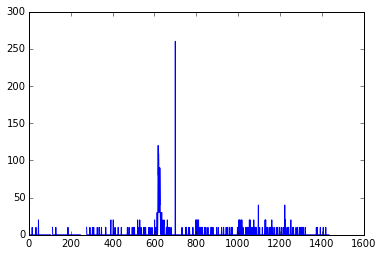

In [3]:
data = pd.read_csv('calls.csv')
vec = data['calls'].values
changepoint = data['event'].values.nonzero()[0][0]

plt.plot(vec)

If this sort of thing interests you, or you think you could teach me a thing or two I am looking for more [Real-Time Analytics Engineers](https://jobs.netflix.com/jobs/2259/apply) for the Real-Time Analytics team at Netflix. Apply online, but definitely personally reach out to me at the conference or crioux AT netflix DOT com.

# Further Research


[1] Paul Fearnhead, Exact and Efficient Bayesian Inference for Multiple                                    
    Changepoint problems, Statistics and computing 16.2 (2006), pp. 203--213                               
                                                                                                           
[2] Ryan P. Adams, David J.C. MacKay, Bayesian Online Changepoint Detection,                               
    arXiv 0710.3742 (2007)                                                                                 
                                                                                                           
[3] Xuan Xiang, Kevin Murphy, Modeling Changing Dependency Structure in                                    
    Multivariate Time Series, ICML (2007), pp. 1055--1062